In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import copy
import itertools
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import operator
import scipy.stats as stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity

import datajoint as dj
import spyglass
from spyglass.common import (Session, IntervalList, LabMember, LabTeam, Raw, Session, Nwbfile, TaskEpoch,
                             Electrode, ElectrodeGroup, LFP, LFPSelection, LFPBand, LFPBandSelection)
from spyglass.common.common_position import (RawPosition, IntervalPositionInfo)

os.chdir("/home/jguidera/Src/MS_analysis_sam/")
from Task_event.ms_dio_event import DioEvents, ProcessedDioEvents
from Metadata.ms_task_identification import TaskIdentification
from Time_and_trials.ms_interval import EpochIntervalListName
from Metadata.metadata_helpers import get_ms_nwbf_epoch_keys
from Utils.df_helpers import df_pop, df_filter1_columns, df_from_data_list
from Datajoint_nwb_utils.nwbf_helpers import get_nwb_file
from Datajoint_nwb_utils.datajoint_table_helpers import format_nwb_file_name
from Utils.vector_helpers import unpack_single_element
from Utils.plot_helpers import format_ax
from Utils.stats_helpers import average_confidence_interval, circular_shuffle
from Utils.point_process_helpers import event_times_in_intervals_bool
from Task_event.ms_task_performance import *


os.chdir("/home/sambray/Documents/behavioral_analysis_AS/")
from AS_EM_module import EM_main

os.chdir("/home/sambray/Documents/MS_analysis_Jen/")

os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol
from IPython.core.display import display, HTML
from Style.style_guide import animal_style
display(HTML("<style>.container { width:100% !important; }</style>")) # set cells to be wide

/tmp/ipykernel_2569348/1122546034.py:43: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
animal_style

## Populate behavior analysis tables

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Populate tables for behavioral analysis of W track sessions
# TODO: get list of nwbf names used in MS analysis
nwb_file_names = ['Frodo20230815_.nwb']

for nwb_file_name in nwb_file_names:
    print(f"on {nwb_file_name}...")
    key = {"nwb_file_name": nwb_file_name}
    TaskIdentification.populate(key)
    epochs = []
    for contingency in ['lineartrack','Lineartrack','wtrack','Wtrack','w-track','W-Track']:
        epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
    # epochs = np.append((TaskIdentification & {**key, **{"contingency": "wtrack"}}).fetch("epoch"),(TaskIdentification & {**key, **{"contingency": "lineartrack"}}).fetch("epoch"))
    for epoch in epochs:
        print(f"on epoch {epoch}...")
        key.update({"epoch": epoch})
        if not EpochIntervalListName & key:
            print('populating epochIntervalListName...')
            EpochIntervalListName.populate(key)
        if not DioEvents & key:
            print ('populating DioEvents...')
            DioEvents.populate(key)
        if not ProcessedDioEvents & key:
            print('populating ProcessedDioEvents...')
            ProcessedDioEvents.populate(key)
        if not AlternationTaskPerformance & key:
            print('populating AlternationTaskPerformance...')
            AlternationTaskPerformanceSel().insert1(key,skip_duplicates=True)
            AlternationTaskPerformance.populate(key)

In [ ]:
x = (ProcessedDioEvents & key).fetch("KEY")[0]
(TaskIdentification & x).fetch1("contingency") in ["wtrack","W-Track","W-track",'wtrack','w-track']
# ProcessedDioEvents & key
AlternationTaskPerformanceSel.insert1(x,skip_duplicates=True)

AlternationTaskPerformanceSel&x #& key

AlternationTaskPerformance.populate(x)
# key

In [ ]:
key = {'nwb_file_name': 'Frodo20230814_.nwb', 'epoch': 10}
# print((ProcessedDioEvents() & key).fetch1_dataframe().dio_event_names.values.size)
wells = (AlternationTaskPerformance & key).fetch('current_wells')[0]
reward = (AlternationTaskPerformance & key).fetch('reward_outcomes')[0]

for w,r in zip(wells,reward):
    print(w,r)  

## Get performance outcomes across epochs on w track, for each animal and for each trial type

### get non-ms animals

In [4]:
def get_file_contents(file_name, file_path=None):

    if file_path is not None:
        os.chdir(file_path)

    file_obj = open(file_name, "r")
    file_contents = file_obj.read()
    file_obj.close()

    return file_contents

# Convert task performance to binary
def get_binary_performance(outcomes):
    binary_performance_vals = []
    for x in outcomes:
        first_part = x.split("_")[0]
        if first_part == "incorrect":
            binary_performance_vals.append(0)
        elif first_part == "correct":
            binary_performance_vals.append(1)
    return binary_performance_vals

In [5]:
# Initialize variable for storing data for df
data_list_non_ms = []

# Add data from non-MS cohort
cohort_type = "non_MS"

# Define non-MS animals
non_ms_subject_ids = ["Jaq", "Lotus", "Monty", "Roqui"]

for subject_id in non_ms_subject_ids:
    
    # Change to directory with behavior results
    try:
        os.chdir(f"/stelmo/abhilasha/collabs/{subject_id}_wtrack_statescripts")
    except:
         os.chdir(f"/stelmo/abhilasha/collabs/{subject_id}_wtrack_statescript")
       
    # Get file names
    file_names = os.listdir()

    # Get percent correct, and number of trials
    performance_outcomes_map = dict()
    
    for file_name in file_names:

        # Get file contents
        file_contents = get_file_contents(file_name)

        # Split by new line
        file_contents = file_contents.split("\n")

        # Drop comment lines
        file_contents_ = []
        for x in file_contents:
            if len(x) > 0:
                if x[0] != "#":
                    file_contents_.append(x)
        file_contents = file_contents_

        # Save only UP and DOWN lines
        file_contents = [x for x in file_contents if any([z in x for z in ["UP", "DOWN"]])]

        # Drop initial number 
        file_contents = [x.split(" ")[1:] for x in file_contents]

        # Get rid of repeat ups and downs at same well
        last_up, last_down = np.nan, np.nan
        ups, downs = [], []
        for x, y in file_contents:
            if x == "UP":
                current_up = int(y)
                if current_up != last_up:
                    ups.append(copy.deepcopy(current_up))
                    last_up = current_up
            elif x == "DOWN":
                current_down = int(y)
                if current_down != last_down:
                    downs.append(copy.deepcopy(current_down))
                    last_down = current_down

        if ups[:len(downs)] != downs:
            raise Exception("ups not same as downs; this is unexpected")

        # Replace numbers with well visit text
        replace_nums_map = {2: "home", 1: "outer_1", 3: "outer_2"}
        well_visits = [replace_nums_map[x] for x in ups]

        # Parse well visits into correct and incorrect
        previous_well = None
        previous_outer_well = None

        performance_outcomes = []
        for idx, current_well in enumerate(well_visits):

            # Check that current well not same as previous well
            if current_well == previous_well:
                raise Exception

            # Correct outbound 
            if previous_well == "home" and np.logical_or(
                current_well == "outer_1" and previous_outer_well == "outer_2", 
                current_well == "outer_2" and previous_outer_well == "outer_1"):
                performance_outcomes.append("correct_outbound")

            # Correct inbound
            elif (previous_well == "outer_1" or previous_well == "outer_2") and current_well == "home":
                performance_outcomes.append("correct_inbound")

            # Incorrect outbound 
            elif previous_well == "home" and np.logical_or(
                current_well == "outer_1" and previous_outer_well == "outer_1", 
                current_well == "outer_2" and previous_outer_well == "outer_2"):
                performance_outcomes.append("incorrect_outbound")

            # Incorrect inbound 
            elif np.logical_or(
                current_well == "outer_1" and previous_well == "outer_2", 
                current_well == "outer_2" and previous_well == "outer_1"):
                performance_outcomes.append("incorrect_inbound")

            # First home
            elif current_well == "home" and previous_well is None:
                performance_outcomes.append("first_home")

            # First outer 
            elif (current_well == "outer_1" or current_well == "outer_2") and previous_outer_well is None:
                performance_outcomes.append("first_outer")

            # Not assigned 
            else:
                raise Exception

            # Set previous well to current well
            previous_well = current_well

            # Set previous outer well if indicated
            if current_well == "outer_1" or current_well == "outer_2":
                previous_outer_well = current_well

        # Store
        split_file_name = file_name.split("_")
        date = split_file_name[0]
        epoch = int(split_file_name[2])
        
        data_list_non_ms.append((subject_id, date, epoch, cohort_type, performance_outcomes))

In [ ]:
file_names

### get ms animal data


In [50]:
# Get performance outcomes across epochs on w track, for each animal and for each trial type
#single day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb",],#"Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb",],#"Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb",],# "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb",],# "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb",],#"Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  # entrainment  # 
# Multiple day
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb","Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb",],# "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  

# #Frodo with and without stim
# nwb_file_names_map = {
#     "Frodo_stim": ["Frodo20230814_.nwb","Frodo20230815_.nwb"],
#     "Frodo_no_stim": ["Frodo20230815_.nwb","Frodo20230816_.nwb"]
# }

# entrainment  # 
# nwb_file_names_map = {"Frodo":["Frodo20230814_.nwb","Frodo20230815_.nwb","Frodo20230816_.nwb",]}
# nwb_file_names_map = {"Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],}
# nwb_file_names_map = {"Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"]}
# nwb_file_names_map={"Wallie": ["Wallie20220922_.nwb"],"Totoro": ["Totoro20220613_.nwb","Totoro20220614_.nwb"]}#"Banner":["Banner20220224_.nwb"]}
# nwb_file_names_map = {"Banner24":["Banner20220224_.nwb",],
#                      "Banner25":["Banner20220225_.nwb"],
#                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb",]} 
trial_types = ["all", "outbound", "inbound"]
optogenetic_types = ['control','test', "all"]

data_list = []  # initialize list to store correct/incorrect outcomes 
# For nwb file names

for optogenetics in optogenetic_types:
    for rat_name, nwb_file_names in nwb_file_names_map.items():
        # Loop through trial types
        for trial_type in trial_types:
            resp_values = []
            # Loop through epochs where contingency is wtrack
            total_trial_count = 0
            trial_number = []
            for nwb_file_name in nwb_file_names:
                key = {"nwb_file_name": nwb_file_name}
                # Get epochs where contingency is wtrack
                epochs = []
                for contingency in ['wtrack','w-track']:
                    epochs.extend((TaskIdentification & {**key, **{"contingency": contingency}}).fetch("epoch"))
                if rat_name=='Frodo_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = [2,4]
                if rat_name=='Frodo_no_stim' and nwb_file_name=='Frodo20230815_.nwb':
                    epochs = np.array(epochs)
                    epochs = epochs[epochs>5]
                print(key)
                print('Epochs:',epochs)
                
                for epoch in epochs:
                    key.update({"epoch": epoch})
    
                    # Get performance outcomes
                    table_intersection = (AlternationTaskPerformance & key)
                    if len(table_intersection) == 0:
                        print(f"no entry found in AlternationTaskPerformance for {key}")
                        continue
                    performance_outcomes = table_intersection.fetch1("performance_outcomes")
                    #SB: restrict by optogenetic period or control
                    if optogenetics in ['test','control']:
                        poke_event_times = (ProcessedDioEvents.FirstUpPokes() & key).fetch1("dio_first_poke_times")
                        # get the control interval
                        if EpochIntervalListName()&key:
                            pos_interval_name = (EpochIntervalListName()&key).fetch1('interval_list_name')
                            dio_info_key = {"nwb_file_name": nwb_file_name, "interval_list_name":pos_interval_name, 'dio_event_name':'stim'}
                            control_interval = OptoStimProtocol().get_control_intervals(dio_info_key)#[0][0]
                            if len(control_interval)==0:
                                print('missing parameterized optogenetics: ', dio_info_key)
                                continue
                            control_interval=control_interval[0][0]
                        else:
                            print(f'No position tracking for {key}. Assuming no stimulus interval')
                            control_interval = [0,1e20]
 
                        #label each event as in test or control
                        optogenetic_event = [(event_time<control_interval[0] or event_time>control_interval[1]) for event_time in poke_event_times]
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            optogenetic_event = [y for (x,y) in zip(performance_outcomes,optogenetic_event) if trial_type in x]
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                        #filter on condition
                        performance_outcomes = [x for (x,opto) in zip(performance_outcomes,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]             
                        epoch_trial_number = [x for (x,opto) in zip(epoch_trial_number,optogenetic_event) if ((opto and optogenetics=='test') or ((not opto) and optogenetics=='control'))]
                        
                    else: #no optogenetic restriction
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            performance_outcomes = [x for x in performance_outcomes if trial_type in x]
                        epoch_trial_number = np.arange(len(performance_outcomes)) + total_trial_count
                        total_trial_count += len(epoch_trial_number)
                    
                    # Convert to binary
                    performance_outcomes = np.asarray(performance_outcomes_to_int(performance_outcomes))
    
                    # Remove nans
                    resp_values.extend(performance_outcomes[np.isfinite(performance_outcomes)])
                    trial_number.extend(np.array(epoch_trial_number)[np.isfinite(performance_outcomes)])
                    
            # Store result
            data_list.append((rat_name, trial_type, resp_values, optogenetics, trial_number))
# Convert results to df
res_values_df = df_from_data_list(data_list, ["rat_name", "trial_type", "resp_values", "optogenetic_type", "trial_number"])

{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Bilbo20230802_.nwb'}
Epochs: [

## Merge the two sets

In [51]:


non_ms_df = df_from_data_list(data_list_non_ms, [
    "subject_id", "date", "epoch", "cohort_type", "performance_outcomes"]) 
non_ms_df_formatted = []
for subject in non_ms_df.subject_id.unique():
    base_entry = {"rat_name":subject,
                 "optogenetic_type":"control"}
    
    subject_df = non_ms_df[non_ms_df.subject_id==subject]
    epoch_list = subject_df.epoch.values
    epoch_list.sort()
    outcomes = []
    for epoch in epoch_list:
        outcomes.extend(subject_df[subject_df.epoch==epoch].performance_outcomes.values[0])
    outcomes = np.array([x for x in outcomes if not "first" in x])
    accuracy = np.array([int("incorrect" not in x) for x in outcomes])
    trial_type = np.array([x.split("_")[-1] for x in outcomes])
    
    all_trial_entry ={**base_entry,
                      "trial_type":"all",
                      "resp_values":accuracy,
                      "trial_number":list(np.arange(len(accuracy))),
                      }
    
    ind = (trial_type=="outbound")
    outbound_entry = {**base_entry,
                      "trial_type":"outbound",
                      "resp_values":accuracy[ind],
                      "trial_number":np.arange(ind.sum())
    }
    ind = (trial_type=="inbound")
    inbound_entry = {**base_entry,
                      "trial_type":"inbound",
                      "resp_values":accuracy[ind],
                      "trial_number":np.arange(ind.sum())
    }
    non_ms_df_formatted.extend([all_trial_entry,outbound_entry, inbound_entry])
    
    
df_2=pd.DataFrame(non_ms_df_formatted)

res_values_df = pd.concat([res_values_df,df_2])
# res_values_df_
# epoch_list

# Plot Learning curves

In [ ]:
nwb_file_names_map = {
                      "Yoshi": ["Yoshi20220517_.nwb","Yoshi20220518_.nwb",],
                      "Olive": ["Olive20220711_.nwb"],
                      "Wallie": ["Wallie20220922_.nwb"],
                      "Bilbo":["Bilbo20230802_.nwb","Bilbo20230804_.nwb"],# no entrainment
                      "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
                      "Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],
                      "Banner":["Banner20220224_.nwb","Banner20220225_.nwb"],
                      "Frodo":["Frodo20230814_.nwb",],#"Frodo20230815_.nwb","Frodo20230816_.nwb",]
                      }  



<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2502074/634988009.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optogenetics is "test":


sigma2e: 0.25
Converged after 278 iterations
sigma2e is  0.019127260759661122


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 408 iterations
sigma2e is  0.011235810878329556


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 465 iterations
sigma2e is  0.010599751711422837


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 270 iterations
sigma2e is  0.017018839646159776


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 268 iterations
sigma2e is  0.00817694816270138


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 360 iterations
sigma2e is  0.006397938383705911


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 205 iterations
sigma2e is  0.1262273663157757


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.13977807871021583


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 344 iterations
sigma2e is  0.08763365778640711


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 227 iterations
sigma2e is  0.09915476868595878


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.013225785358501392


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 320 iterations
sigma2e is  0.010114707003687922


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 92 iterations
sigma2e is  0.2448017776016345


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 272 iterations
sigma2e is  0.02545366456488305


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 317 iterations
sigma2e is  0.019921773891533368


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 129 iterations
sigma2e is  0.1776008184873779


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 271 iterations
sigma2e is  0.06238394183718512


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 311 iterations
sigma2e is  0.04720097201147402


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 242 iterations
sigma2e is  0.012800290968438755


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 274 iterations
sigma2e is  0.006741741800896018


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 279 iterations
sigma2e is  0.00455944486033512


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 259 iterations
sigma2e is  0.006382929799813952


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 300 iterations
sigma2e is  0.00418453648583955


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 291 iterations
sigma2e is  0.003752316003526118


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 192 iterations
sigma2e is  0.14438423448715051


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 399 iterations
sigma2e is  0.14223708438086588


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 458 iterations
sigma2e is  0.07947815991470117


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 207 iterations
sigma2e is  0.012414148630620023


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 360 iterations
sigma2e is  0.00998516488028729


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 364 iterations
sigma2e is  0.005623081412203776


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 216 iterations
sigma2e is  0.023595512478769943


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 235 iterations
sigma2e is  0.007657361673643653


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 255 iterations
sigma2e is  0.004947276306624864


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 181 iterations
sigma2e is  0.09797998187113825


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 204 iterations
sigma2e is  0.15839555374751615


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 295 iterations
sigma2e is  0.08345104428987841


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 224 iterations
sigma2e is  0.009995057487287202


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 263 iterations
sigma2e is  0.002242077768721499


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 274 iterations
sigma2e is  0.0021385543695043815


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 258 iterations
sigma2e is  0.0019346565729511272


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 320 iterations
sigma2e is  0.002400164855646392


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 294 iterations
sigma2e is  0.0015748559901246878


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 171 iterations
sigma2e is  0.09617896136907125


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 334 iterations
sigma2e is  0.06693413518205646


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 385 iterations
sigma2e is  0.03841047218029714


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 253 iterations
sigma2e is  0.018655442653900123


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 385 iterations
sigma2e is  0.014645986895263915


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 386 iterations
sigma2e is  0.01300010006513072


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 190 iterations
sigma2e is  0.030948971104164533


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 316 iterations
sigma2e is  0.01971979633755384


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 356 iterations
sigma2e is  0.014318469924518793


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 250 iterations
sigma2e is  0.10656658330180872


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 269 iterations
sigma2e is  0.08046923910665191


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 325 iterations
sigma2e is  0.061395690907707065


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 353 iterations
sigma2e is  0.012519198879906995


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 377 iterations
sigma2e is  0.006177248009774466


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 351 iterations
sigma2e is  0.005728596058176233


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 512 iterations
sigma2e is  0.0027348695251185606


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 409 iterations
sigma2e is  0.007281702081053736


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 329 iterations
sigma2e is  0.010522684214091372


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 190 iterations
sigma2e is  0.10142261198304194


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 417 iterations
sigma2e is  0.09398789275309775


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 412 iterations
sigma2e is  0.058156246915710086


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 239 iterations
sigma2e is  0.01624241974233781


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 337 iterations
sigma2e is  0.003808053027824427


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 299 iterations
sigma2e is  0.003160698294083285


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 236 iterations
sigma2e is  0.0016474975488908676


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 313 iterations
sigma2e is  0.002222008228441864


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 310 iterations
sigma2e is  0.001913963814381868


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 109 iterations
sigma2e is  0.1655904705774191


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 403 iterations
sigma2e is  0.03188188541921167


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 376 iterations
sigma2e is  0.02054817741298134


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 381 iterations
sigma2e is  0.03072018536366425


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 329 iterations
sigma2e is  0.024844982685894863


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 388 iterations
sigma2e is  0.10809632713333817


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 344 iterations
sigma2e is  0.046532298362129236


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 255 iterations
sigma2e is  0.06099124935592372


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 249 iterations
sigma2e is  0.1556907133389509


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 306 iterations
sigma2e is  0.016179338394275898


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 295 iterations
sigma2e is  0.01043808027237191


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 168 iterations
sigma2e is  0.1944953748389571


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 268 iterations
sigma2e is  0.0034370536783565387


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 387 iterations
sigma2e is  0.009536593087092171


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


sigma2e: 0.25
Converged after 262 iterations
sigma2e is  0.005310692552623766


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2502074/634988009.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


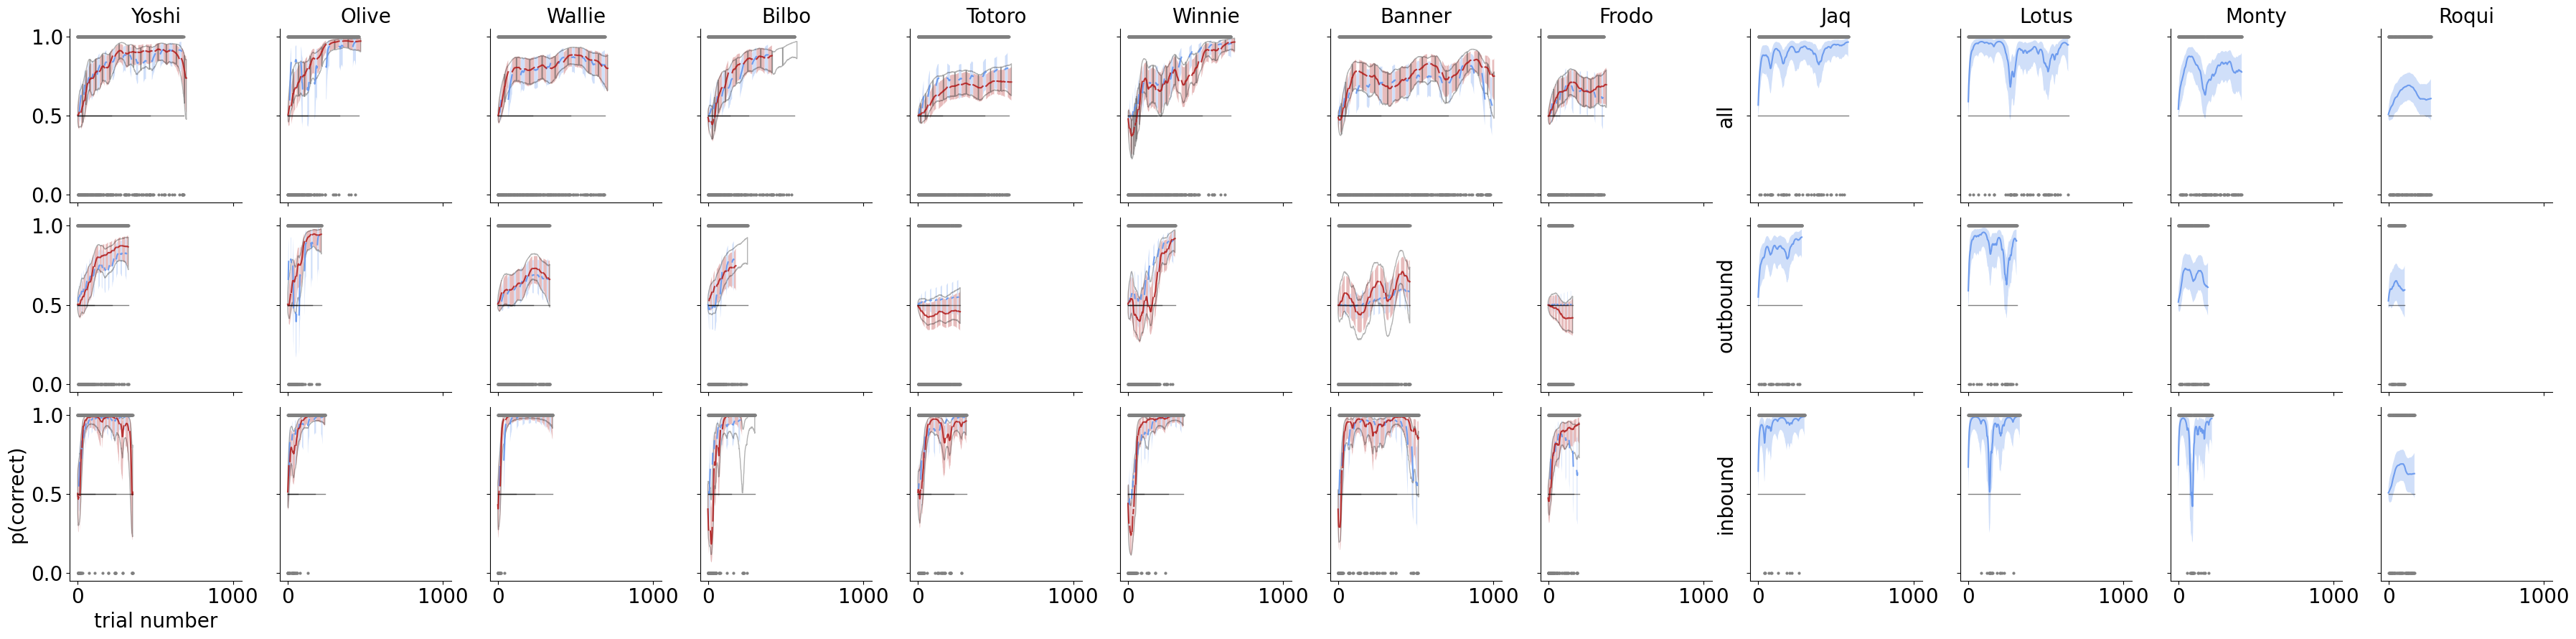

In [28]:
os.chdir("/home/sambray/Documents/behavioral_analysis_AS")
from AS_EM_module import EM_main, RunEM

# Plot parameters
p_init = .5
subplot_width = 3
subplot_height = 3

plot_animals = res_values_df.rat_name.unique()
# Initialize figure
num_columns = max(len(plot_animals),2)
num_rows = len(trial_types)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(subplot_width*num_columns, subplot_height*num_rows), sharex=True, sharey=True)

# Plot learning curves
data_list = []
# plot_animals = list(nwb_file_names_map.keys())


for rat_name_idx, rat_name in enumerate(plot_animals):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics,color in zip (optogenetic_types,['cornflowerblue','firebrick','none']) :
            if not len(res_values_df[np.logical_and(res_values_df.rat_name==rat_name,
                                     res_values_df.optogenetic_type==optogenetics)]):
                continue
            
            resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "resp_values")
            trial_number = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}, "trial_number")
            if len(resp_values) == 0:
                continue
            fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(resp_values, p_init, fig_ax_list,color=color,label=optogenetics,trial_number=trial_number)
            # Store lower limit 
            data_list.append((rat_name, trial_type, pll,optogenetics,trial_number,pmode))
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map)-1:
                ylabel=trial_type
                ax.yaxis.set_label_position("right")
        format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()
        
# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]
pll_df = df_from_data_list(data_list, ["rat_name", "trial_type", "pll","optogenetic_type","trial_number","pmode"])
learning_trials = [get_first_entry_else_nan(np.where(pll > .5)[0]) for pll in pll_df.pll]
def indxVal_else_nan(values,indx):
    if indx is np.nan:
        return np.nan
    return values[indx]
learning_trials = [indxVal_else_nan(trial_number,ind) for(trial_number, ind) in zip(pll_df.trial_number,learning_trials)]
pll_df["learning_trial"] = learning_trials

# for rat_name_idx, rat_name in enumerate(nwb_file_names_map.keys()):
#     for trial_type_idx, trial_type in enumerate(trial_types):
#         for loc,(optogenetics,color) in enumerate(zip(optogenetic_types,['cornflowerblue','firebrick'])):
#             resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "resp_values")
#             if len(resp_values) == 0:
#                 continue
#             learning_trial = df_pop(pll_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "learning_trial")
#             ax = axes[trial_type_idx, rat_name_idx]
#             ax.text(0, .25+.1*loc, learning_trial, fontsize=20,color=color)
# axes[0,0].legend(loc='lower right',title='optogenetics')

In [ ]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.png')
fig.savefig('20230724_wTrack_curves_separated_globalTrialCount_gap.svg')

## Learning Trial comparison (within animal)

In [ ]:
trial_type = 'outbound'
control_rats = ["Yoshi", "Olive", "Wallie","Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner","Frodo"]
set_nan = 340
df_ = pll_df[(pll_df['trial_type']==trial_type)].copy()

included_nan = False
for rat_set, color in zip([control_rats, opto_rats],['cornflowerblue','firebrick']):
    label = f'{rat_set=}'
    for rat_name in rat_set:
        lt_test = df_[(df_['optogenetic_type']=='test') & (df_['rat_name']==rat_name)]['learning_trial']
        lt_control = df_[(df_['optogenetic_type']=='control') & (df_['rat_name']==rat_name)]['learning_trial']
        if any(np.isnan([lt_test,lt_control])):# or np.isnan(lt_control):
            included_nan = True
        lt_test = np.nan_to_num(lt_test,nan=set_nan)
        lt_control = np.nan_to_num(lt_control,nan=set_nan)
        plt.scatter([0,1],[lt_control,lt_test,], color=color,label=label)
        plt.plot([0,1],[lt_control,lt_test,], color=color,ls=':', alpha=.5)
        label = None

plt.legend()
plt.xticks([0,1],labels=['optogenetics_control','otpogenetics_test'])
plt.ylabel('learning trial')
plt.title(f'trial type: {trial_type} task')
plt.xlim(-.15,1.15)
if included_nan:
    plt.fill_between([-1,2],[set_nan-10,set_nan-10],[set_nan-50,set_nan-50],facecolor='grey',alpha = .3)
    yticks = np.append(np.arange(0,251,50),[set_nan])
    yticks_labels = list(yticks.copy())
    yticks_labels[-1] = 'not learned'
    
    plt.yticks(yticks,labels=yticks_labels)

## Learning Trial comparison between animals

Jaq 0.0 4.0 1.0
Lotus 0.0 1.0 0.0
Monty 0.0 19.0 3.0
Roqui 33.0 34.0 35.0
Yoshi 22.0 64.0 43.0
Olive 8.0 26.0 14.0
Wallie 20.0 40.0 22.0
Bilbo 41.0 66.0 61.0
Totoro 36.0 340.0 63.0
Winnie 54.0 170.0 80.0
Banner 28.0 222.0 47.0
Frodo 23.0 355.0 39.0


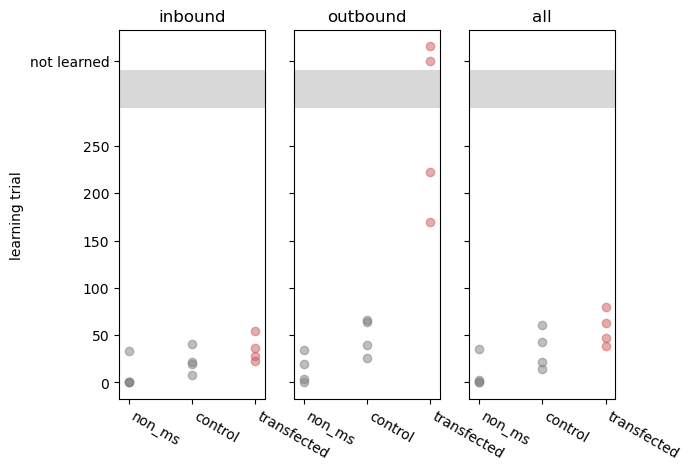

In [33]:
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from Style.style_guide import animal_style

seperate_non_ms = True
trial_type = "outbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
# non_ms_rats =
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]

set_nan = 340
df_ = pll_df  # [(pll_df['trial_type']==trial_type)].copy()

trial_type = "all"  # optogenetic trial type
fig, ax = plt.subplots(ncols=3, sharey=True)
included_nan = False
rat_sets = [control_rats, opto_rats]
set_colors = [
            animal_style.loc[control_rats[0], "background"],
            animal_style.loc[opto_rats[0], "background"],
        ]
if seperate_non_ms:
    rat_sets = [non_ms_rats] +rat_sets
    set_colors = ["grey"] + set_colors

for i, (rat_set, color) in enumerate(
    zip(
        rat_sets,
        set_colors
    )
):
    label = f"{rat_set=}"
    for ii, (rat_name) in enumerate(rat_set):
        if rat_name in non_ms_rats and trial_type == "all":
            trial_type_i = "control"
        else:
            trial_type_i = trial_type

        lt_in = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == "inbound")
        ]["learning_trial"].values[0]
        lt_out = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == "outbound")
        ]["learning_trial"].values[0]
        lt_all = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == trial_type)
        ]["learning_trial"].values[0]
        if any(np.isnan([lt_in, lt_out])):  # or np.isnan(lt_control):
            included_nan = True
        lt_out = np.nan_to_num(lt_out, nan=set_nan + ii * 5)
        lt_in = np.nan_to_num(lt_in, nan=set_nan + ii * 5)
        ax[0].scatter([i], [lt_in], color=color, label=label, alpha=0.5)
        ax[1].scatter([i], [lt_out], color=color, label=label, alpha=0.5)
        ax[2].scatter([i], [lt_all], color=color, label=label, alpha=0.5)
        label = None
        print(rat_name, lt_in, lt_out, lt_all)
if included_nan:
    for a in ax:
        a.fill_between(
            [-1, 3],
            [set_nan - 10, set_nan - 10],
            [set_nan - 50, set_nan - 50],
            facecolor="grey",
            alpha=0.3,
        )
        yticks = np.append(np.arange(0, 251, 50), [set_nan])
        yticks_labels = list(yticks.copy())
        yticks_labels[-1] = "not learned"
        a.set_yticks(yticks, labels=yticks_labels)
        a.set_xlim(-0.15, len(rat_sets)-.85)
set_labels = ["control","transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
for a in ax:
    a.set_xticks(np.arange(len(set_labels)))
    a.set_xticklabels(labels=set_labels,rotation=-30,ha="left")
ax[0].set_title("inbound")
ax[1].set_title("outbound")
ax[2].set_title("all")
ax[0].set_ylabel("learning trial")

separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams['svg.fonttype']='none'
fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/behavior_learning_trial_{separated_tag}.svg")

# Correct Fraction First n trials

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


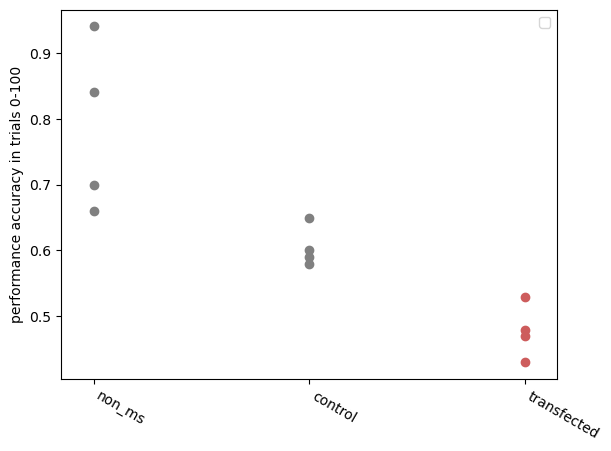

In [36]:

seperate_non_ms = True
trial_type = "outbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
trial_sample = (0, 100)
optogenetic_type = "all"
fig = plt.figure()
ax = fig.gca()

df_ = res_values_df[(res_values_df["trial_type"] == trial_type)].copy()
results = []
rat_sets = [control_rats, opto_rats]
set_colors = [
            animal_style.loc[control_rats[0], "background"],
            animal_style.loc[opto_rats[0], "background"],
        ]
if seperate_non_ms:
    rat_sets = [non_ms_rats] +rat_sets
    set_colors = ["grey"] + set_colors

for i, (rat_set, color) in enumerate(
    zip(rat_sets, set_colors)
):
    results.append([])
    for rat_name in rat_set:
        if rat_name in non_ms_rats and optogenetic_type=="all":
            optogenetic_type_i = "control"
        else:
            optogenetic_type_i = optogenetic_type
        lt_test = np.mean(
            np.asarray(
                df_[
                    (df_["optogenetic_type"] == optogenetic_type_i) & (df_["rat_name"] == rat_name)
                ]["resp_values"]
            )[0][trial_sample[0] : trial_sample[1]]
        )
        results[-1].append(lt_test)
    plt.scatter(np.ones_like(results[-1]) * i, results[-1], color=color)


plt.legend()
set_labels = ["control","transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
ax.set_xticks(np.arange(len(set_labels)))
ax.set_xticklabels(labels=set_labels,rotation=-30,ha="left")
plt.ylabel("learning trial")
plt.ylabel(f"performance accuracy in trials {trial_sample[0]}-{trial_sample[1]}")
plt.xlim(-0.15, len(rat_sets)-.85)

from scipy.stats import ttest_ind

plt.title(f"trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}")
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams['svg.fonttype']='none'
fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/behavior_accuracy_{separated_tag}.svg")

In [ ]:
plt.rcParams['svg.fonttype']='none'
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/Plots/')
filename = '20230724_performance_accuracy'
fig.savefig(filename+'.png')
fig.savefig(filename+'.svg')

In [ ]:
df_[df_['optogenetic_type']=='test']
res_values_df[(pll_df['trial_type']==trial_type)].copy()

### Learning curve slope

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


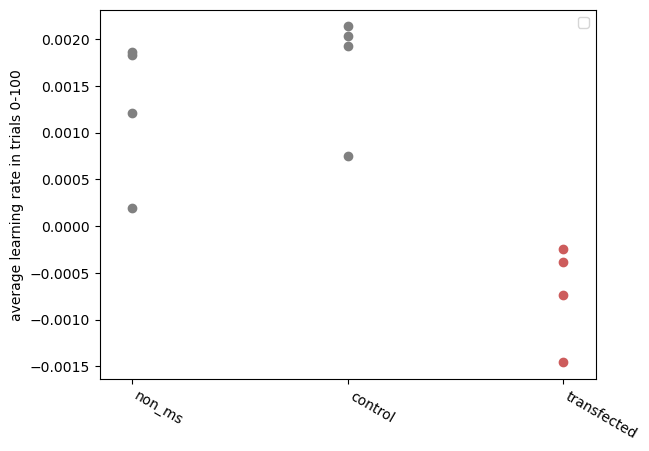

In [39]:
from scipy.stats import linregress

seperate_non_ms =True
trial_type = "outbound"
optogenetic_type = "all"

control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
trial_sample = (0, 100)

df_ = pll_df[(pll_df["trial_type"] == trial_type)].copy()

fig = plt.figure()
ax = fig.gca()
results = []
rat_sets = [control_rats, opto_rats]
set_colors = [
            animal_style.loc[control_rats[0], "background"],
            animal_style.loc[opto_rats[0], "background"],
        ]
if seperate_non_ms:
    rat_sets = [non_ms_rats] +rat_sets
    set_colors = ["grey"] + set_colors
for i, (rat_set, color) in enumerate(
    zip(rat_sets, set_colors)
):
    results.append([])
    for rat_name in rat_set:
        if rat_name in non_ms_rats and optogenetic_type == "all":
            optogenetic_type_i = "control"
        else:
            optogenetic_type_i = optogenetic_type

        pmode = np.asarray(
            df_[
                (df_["optogenetic_type"] == optogenetic_type_i)
                & (df_["rat_name"] == rat_name)
            ]["pmode"]
        )[0][trial_sample[0] : trial_sample[1]]
        trial_number = np.asarray(
            df_[
                (df_["optogenetic_type"] == optogenetic_type_i)
                & (df_["rat_name"] == rat_name)
            ]["trial_number"]
        )[0][trial_sample[0] : trial_sample[1]]
        slope = linregress(trial_number, pmode)[0]
        results[-1].append(slope)
    plt.scatter(np.ones_like(results[-1]) * i, results[-1], color=color)

plt.legend()
set_labels = ["control","transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
ax.set_xticks(np.arange(len(set_labels)))
ax.set_xticklabels(labels=set_labels,rotation=-30,ha="left")
plt.ylabel(f"average learning rate in trials {trial_sample[0]}-{trial_sample[1]}")
plt.xlim(-0.15, len(rat_sets)-.85)

from scipy.stats import ttest_ind

# plt.title(f"trial type: {trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}")
plt.rcParams["svg.fonttype"] = "none"
# figname = "/home/sambray/Documents/MS_analysis_samsplaying/Plots/Abhilashsa_20220724/behavior/learning_rate"
# fig.savefig(figname + ".png")
# fig.savefig(figname + ".svg")
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams['svg.fonttype']='none'
fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/behavior_learning_rate_{separated_tag}.svg")

## Jen's Learning curve version

0.75 0.845
0.72 0.815
0.782051282051282 0.8846153846153846
0.7253521126760564 0.8380281690140845
0.5347500000000001 0.65
0.565 0.675
0.77 0.86
0.735 0.83
0.45 0.565
0.39 0.505
0.395 0.515
0.44025157232704404 0.5723270440251572


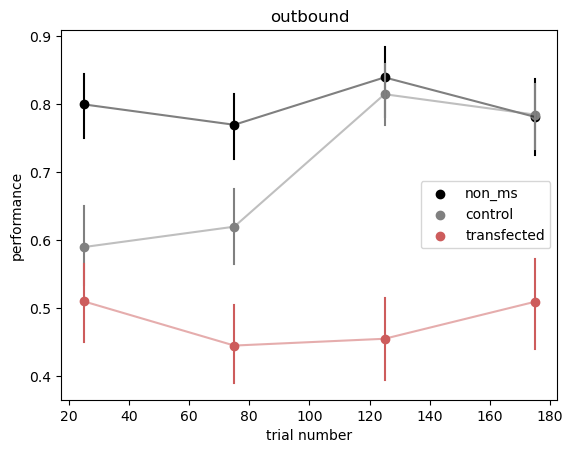

In [27]:
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]

seperate_non_ms = True
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
optogenetic_type = "all"
trial_type = "outbound"
bin_size = 50
max_trials = 200

animal_set = opto_rats
color = 'grey'


fig = plt.figure()
ax = fig.gca()
rat_sets = [control_rats, opto_rats]
set_colors = [
            animal_style.loc[control_rats[0], "background"],
            animal_style.loc[opto_rats[0], "background"],
        ]
set_labels = ["control","transfected"]
if seperate_non_ms:
    rat_sets = [non_ms_rats] +rat_sets
    set_colors = ["k"] + set_colors
    set_labels = ["non_ms"] + set_labels
for i, (rat_set, color, label) in enumerate(
    zip(rat_sets, set_colors, set_labels)
):

    trial = []
    result = []
    for animal in rat_set:
        if animal in non_ms_rats and optogenetic_type=="all":
            optogenetic_type_i = "control"
        else:
            optogenetic_type_i = optogenetic_type
        animal_df = res_values_df[(res_values_df.rat_name==animal) &
                    (res_values_df.optogenetic_type==optogenetic_type_i) &
                    ((res_values_df.trial_type==trial_type))]
        [trial.extend(x) for x in animal_df.trial_number.values]
        [result.extend(x) for x in animal_df.resp_values.values]
    trial = np.array(trial)  
    result = np.array(result)  
    result = result[trial < max_trials]
    trial = trial[trial<max_trials]
    i = 0
    mid = []
    lo = []
    hi = []
    while i * bin_size<trial.max():
        vals = result[np.logical_and(
            trial>=i*bin_size,
            trial<(i+1)*bin_size
        )]
        mid.append(vals.mean())
        lower_conf, upper_conf = average_confidence_interval(vals)
        lo.append(lower_conf)
        hi.append(upper_conf)
        i+= 1
        
    xx = np.arange(len(mid))* bin_size + bin_size/2.0
    plt.plot(xx,mid,alpha=.5,color=color)
    plt.scatter(xx,mid,color=color,label=label)    
    for x,l,h in zip(xx,lo,hi):
        print(l,h)
        plt.plot([x,x],[l,h],color=color)   
        # break

plt.title(trial_type)
plt.xlabel("trial number")
plt.ylabel("performance")
plt.legend()
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams['svg.fonttype']='none'
fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/behavior_performance_accuracy_bin{bin_size}_{separated_tag}.svg")

# merged EM learning curves

In [30]:
res_values_df[res_values_df.rat_name=="Jaq"]
# {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,}
# # rat_name
# res_values_df[res_values_df.rat_name==rat_name]
# df_pop(res_values_df,
#                                     {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,},
#                                     "resp_values")

,rat_name,trial_type,resp_values,optogenetic_type,trial_number
0,Jaq,all,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",control,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,Jaq,outbound,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...",control,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,Jaq,inbound,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",control,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2569348/1445289249.py:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optogenetics is "test":


sigma2e: 0.25
Converged after 362 iterations
sigma2e is  0.002596293451156582


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


sigma2e: 0.25
Converged after 368 iterations
sigma2e is  0.0025913300603910335


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_2569348/1445289249.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


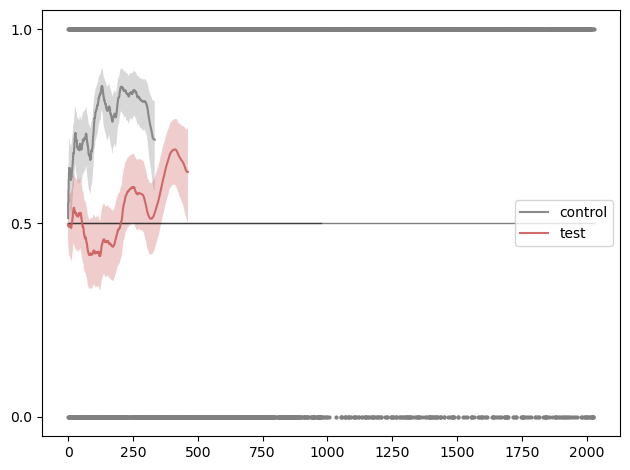

In [58]:
# os.chdir("/home/sambray/Documents/behavioral_analysis_AS")
# from AS_EM_module import EM_main, RunEM
from Style.style_guide import transfection_style
seperate_non_ms = False
trial_type = "outbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
    rat_sets = {"control": control_rats, "test": opto_rats}
else:
    rat_sets = {"control": control_rats, "test": opto_rats, "non_ms": non_ms_rats}
    
trial_sample = (0, 100)
optogenetic_types = ["control"]
fig = plt.figure()
ax = fig.gca()

optogenetic_types = ["all"]
trial_types=["outbound",]


# Plot parameters
p_init = .5
subplot_width = 3
subplot_height = 3

plot_animals = rat_sets.keys()
# Initialize figure
num_columns = max(len(plot_animals),2)
num_rows = len(trial_types)
# fig, axes = plt.subplots(num_rows, num_columns, figsize=(subplot_width*num_columns, subplot_height*num_rows), sharex=True, sharey=True)

# Plot learning curves
data_list = []
# plot_animals = list(nwb_file_names_map.keys())
colors = [transfection_style["control"],
          transfection_style["transfected"],
          'slateblue']

for rat_name_idx, set_name in enumerate(rat_sets):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics,color in zip (optogenetic_types,['cornflowerblue','firebrick','none']) :
            # if not len(res_values_df[np.logical_and(res_values_df.rat_name==rat_name,
            #                          res_values_df.optogenetic_type==optogenetics)]):
            #     continue
            color = colors[rat_name_idx]
            resp_values = []
            trial_number = []
            for rat_name in rat_sets[set_name]:
                if rat_name in non_ms_rats and optogenetics=="all":
                    optogenetic_type_i = "control"
                else:
                    optogenetic_type_i = optogenetics
                resp_values.extend(df_pop(res_values_df,
                                    {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetic_type_i,},
                                    "resp_values"))
                trial_number.extend(df_pop(res_values_df,
                                    {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetic_type_i,},
                                    "trial_number"))
            ind = np.argsort(trial_number)#[:50]
            trial_number = np.array(trial_number)[ind]
            resp_values = np.array(resp_values)[ind]
            
            
            if len(resp_values) == 0:
                continue
            # fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            fig_ax_list = [fig, ax]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(resp_values,
                                               p_init,
                                               fig_ax_list,
                                               color=color,
                                               label=set_name,
                                               trial_number=trial_number)
            # Store lower limit 
            data_list.append((rat_name, trial_type, pll,optogenetics,trial_number,pmode))
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map)-1:
                ylabel=trial_type
                ax.yaxis.set_label_position("right")
        # format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()
    # break
        
        
# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]
pll_df_merged = df_from_data_list(data_list, ["rat_name", "trial_type", "pll","optogenetic_type","trial_number","pmode"])
learning_trials = [get_first_entry_else_nan(np.where(pll > .5)[0]) for pll in pll_df_merged.pll]
def indxVal_else_nan(values,indx):
    if indx is np.nan:
        return np.nan
    return values[indx]
learning_trials = [indxVal_else_nan(trial_number,ind) for(trial_number, ind) in zip(pll_df_merged.trial_number,learning_trials)]
pll_df_merged["learning_trial"] = learning_trials
ax.legend()
# for rat_name_idx, rat_name in enumerate(nwb_file_names_map.keys()):
#     for trial_type_idx, trial_type in enumerate(trial_types):
#         for loc,(optogenetics,color) in enumerate(zip(optogenetic_types,['cornflowerblue','firebrick'])):
#             resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "resp_values")
#             if len(resp_values) == 0:
#                 continue
#             learning_trial = df_pop(pll_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "learning_trial")
#             ax = axes[trial_type_idx, rat_name_idx]
#             ax.text(0, .25+.1*loc, learning_trial, fontsize=20,color=color)
# axes[0,0].legend(loc='lower right',title='optogenetics')

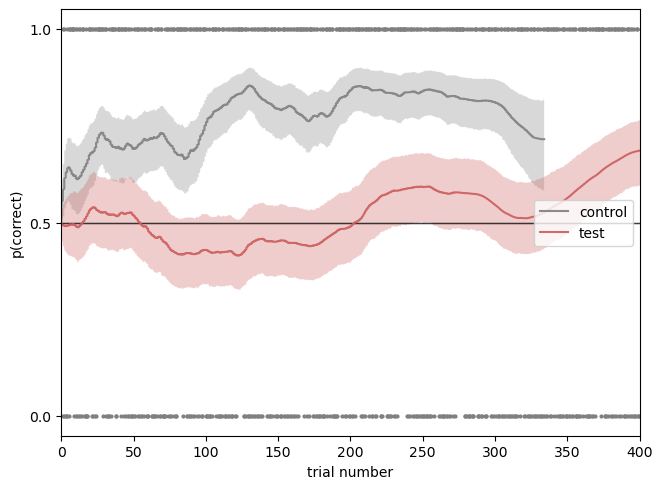

In [60]:
ax.set_xlim(0,400)
ax.set_xlabel('trial number')
ax.set_ylabel('p(correct)')
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams['svg.fonttype']='none'
fig.savefig(f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/behavior_metaEM_{separated_tag}.svg")
# fig.show()
fig

In [46]:
(res_values_df,
                                    {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics,},
                                    "resp_values")

(   rat_name trial_type                                        resp_values  \
 0     Yoshi        all  [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...   
 1     Yoshi   outbound  [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, ...   
 2     Yoshi    inbound  [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...   
 3     Olive        all  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
 4     Olive   outbound  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, ...   
 ..      ...        ...                                                ...   
 7     Monty   outbound  [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, ...   
 8     Monty    inbound  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
 9     Roqui        all  [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ...   
 10    Roqui   outbound  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...   
 11    Roqui    inbound  [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, ...   
 
    optogenetic_type                                       tri